# Dueling Networks from Scratch

The dueling architecture explicitly separates the representation of state values from (state-dependent) action advantage values.

# Imports & Constants

In [1]:
import sys
import os

# Assuming the notebook is located inside `subfolder` and
# we want to import a module in `parent_folder`

# Get the absolute path to the 'subfolder'.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Calculate the path to the 'parent_folder' by going one level up.
parent_dir = os.path.dirname(notebook_dir)

# Add the 'parent_folder' to sys.path if it is not already there.
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [18]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from buffers import ReplayBuffer
import time
from agents import MlpDQNAgent

# Dueling Network

In [5]:
class DuelingNetwork(nn.Module):

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a Duelling Neural Network.
        """
        super().__init__()

        # Common feature layer.
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # Advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        )

        # Value layer
        self.value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        feature = self.feature_layer(x)

        s_value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        q_value = s_value + advantage - advantage.mean(dim=-1, keepdim=True)

        return q_value

# Dueling DQN Agent

In [12]:
class DuelingDQNAgent(MlpDQNAgent):
    """
    Class representing a DQN agent with Dueling Networks.
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        super().__init__(
            env, 
            memory_size, 
            batch_size, 
            target_update, 
            epsilon_decay, 
            seed, 
            max_epsilon, 
            min_epsilon, 
            gamma
        )

        # Networks: DQN behaviour network, DQN target network
        self.dqn = DuelingNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target = DuelingNetwork(self.obs_dim, self.action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model by gradient descent.
        """
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        
        self.optimiser.zero_grad()
        loss.backward()

        # Dueling DQN: We clip the gradients to have their norm less than or equal to 10.
        clip_grad_norm_(self.dqn.parameters(), 10.0)

        self.optimiser.step()

        return loss.item()

# Train an agent

In [13]:
config = {
    'lanes_count': 4,
    'duration': 50,
}

In [14]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")
env.unwrapped.configure(config)
obs, info = env.reset()

In [15]:
seed = 777
num_frames = 200_000
memory_size = 10_000
gamma = 0.85
batch_size = 64
target_update = 50
epsilon_decay = 1 / (num_frames // 10)

agent = DuelingDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


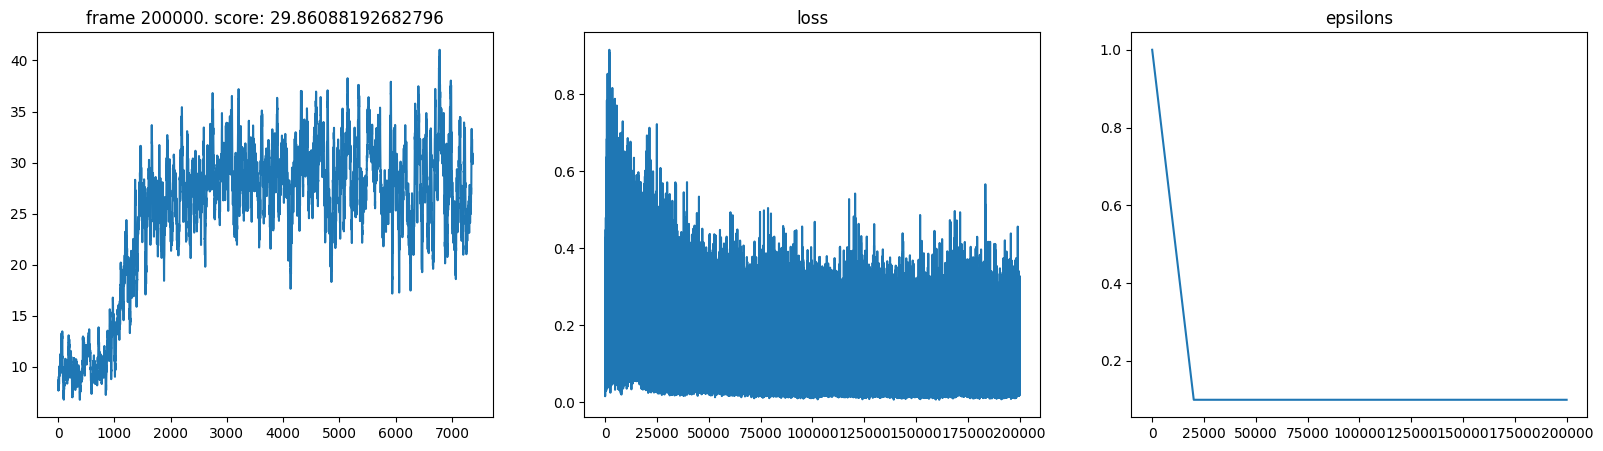

In [16]:
scores, losses, epsilons = agent.train(num_frames)

In [22]:
pd.DataFrame({"Dueling DQN": scores}).to_csv("../results/dueling_dqn.csv")

# Test the agent

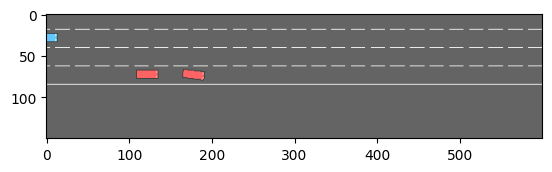

In [17]:
ep_lens, ep_rews = agent.test(5, time_interval=0.1)

In [19]:
print("Mean Episode Length:", np.mean(ep_lens))
print("Mean Score Per Episode:", np.mean(ep_rews))

Mean Episode Length: 33.8
Mean Score Per Episode: 32.59098720742296
